In [13]:
pip install summa

In [14]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

# Step 1. 데이터 수집하기
- 데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용한다.
- [뉴스 기사 데이터](https://github.com/sunnysai12345/News_Summary)

In [15]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [16]:
data.sample(10)

,headlines,text
64355,Fukushima victims appeal for greater compensat...,Victims of Japan's Fukushima disaster have app...
29270,"Panchayat candidate promises Kohli as guest, b...",After promising to bring Virat Kohli as the ch...
49007,I was worried for Under-19 boys during IPL auc...,Indian Under-19 coach Rahul Dravid has said he...
37955,"Australia lost in cricket, FIFA WC, rugby, ten...",Australia on Saturday witnessed losses in cric...
77764,Rahul Gandhi predicts things before they happe...,Bihar CM Nitish Kumar has dismissed Congress V...
66553,Las Vegas shooter had no Islamic terror connec...,The US police have said that the Las Vegas sho...
35316,I will arrest you: Philippine Prez warns ICC p...,Philippine President Rodrigo Duterte has threa...
54388,Will never give up nukes if US continues black...,North Korea on Saturday said it will never giv...
32915,Tinder parent's shares fall 22% as FB reveals ...,Tinder parent Match's shares dropped 22% on Tu...
14610,I introduced Sunny Leone to India: Pooja Bhatt,"Pooja Bhatt, while speaking about breaking nor..."


- 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.
- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.
- 추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

# Step 2. 데이터 전처리하기 (추상적 요약)
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스틑 정규화 또는 정제해 보세요.
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

## 데이터 중복 샘플 제거
- 유일값 개수 세기 : `pandas.unique()`
- 중복 제거 : pandas.drop_duplicates()
<br/><br/>
- text 중복은 제거해야 한다.
- text가 달라도 headlines는 같을 수 있어서 중복 제거를 하지 않는다.

In [17]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [18]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## Null 값 제거하기
- `drop_dulication()`이 중복된 Null들을 지워주기는 하지만, 여전히 Null 값 한 개가 어딘가 남아 있을 것이기 때문에 `.isnull().sum()`을 사용하여 확인할 수 있다.
- 이를 `dropna()` 함수를 사용하여 제거한다.

In [19]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 하지만 이 데이터는 Null값이 존재하지 않다.

## 텍스트 정규화와 불용어 제거
- 같은 의미의 단어들을 같은 표현으로 통일시키기
- 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이다.
- 이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization)이라고 한다.

In [20]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들을 불용어(stopwords)라고 한다.
- NLTK에서 제공하는 불용어 리스트를 참고해, 샘플에서 불용어를 제거할 수 있다.

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- 모든 영어 문자를 소문자로
- 섞여 있는 HTML 태그 제거
- 정규 표현식을 통해 각종 특수문자 제거
- 불용어 제거 : [text] 전처리에서만 사용, [headlines]는 요약 결과문이 자연스러운 문장이 되려면 불용어 제거를 하지 않는 것이 좋다.



In [22]:
from bs4 import BeautifulSoup
import re

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [23]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

# [[YOUR CODE]]
for text in data['text']:
    clean_text.append(preprocess_sentence(text))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [24]:
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

# [[YOUR CODE]]
for headline in data['headlines']:
    clean_headlines.append(preprocess_sentence(headline, remove_stopwords=False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-22-39f432cbf783>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 텍스트 정제의 과정을 거친 후에는 다시 한번 empty 데이터가 있는지 확인.
    - empty 데이터 모두 Null 값으로 대체
    - Null 데이터 제거.

In [25]:
import numpy as np

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

- 여기에서는 다행이 Null 값이 없기 때문에 정제가 완료된 전체 데이터를 확인해보자.

In [26]:
# 정제 후 전체 데이터 확인
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 시작 토큰과 종료 토큰 추가하기
- 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 토큰으로 표시하기.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


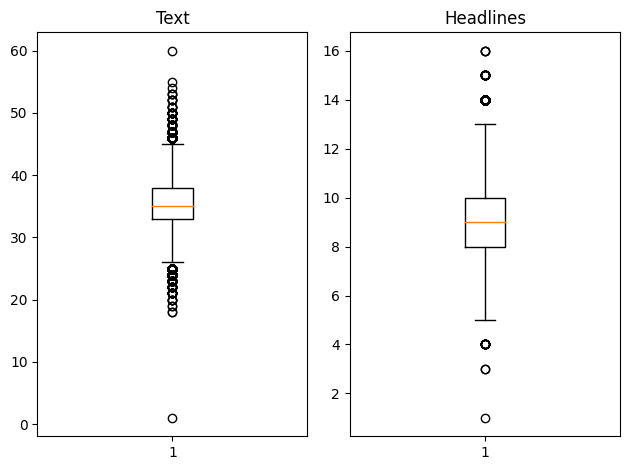

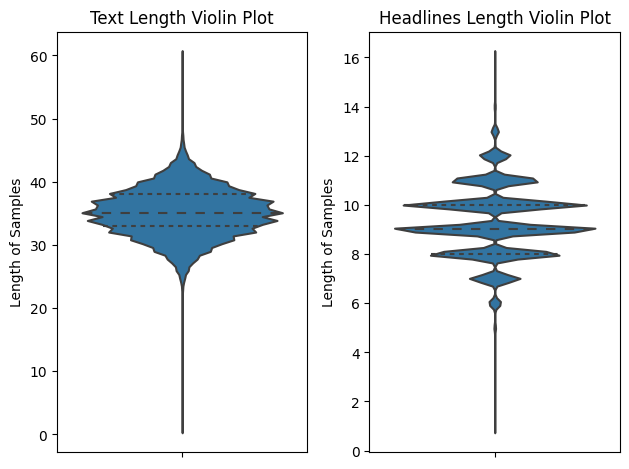

In [27]:
# 길이 분포 출력
import matplotlib.pyplot as plt
import seaborn as sns

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

# Text Length Violin Plot
plt.subplot(1, 2, 1)
sns.violinplot(y=text_len, inner="quartile")
plt.title('Text Length Violin Plot')
plt.ylabel('Length of Samples')

# Headlines Length Violin Plot
plt.subplot(1, 2, 2)
sns.violinplot(y=headlines_len, inner="quartile")
plt.title('Headlines Length Violin Plot')
plt.ylabel('Length of Samples')

plt.tight_layout()
plt.show()


- text는 대체적으로 40 내외의 길이를 가진다.
- headlines는 대체적으로 11 이하의 길이를 가진다.

In [28]:
text_max_len = 40  # text 최대 길이 설정
headlines_max_len = 11  # headlines 최대 길이 설정

- 데이터의 길이가 데이터의 몇 %에 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자.

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [30]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


- 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제해보자.

In [31]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.
- 시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 임의로 명명하고 앞, 뒤로 추가해보자.

In [32]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


- 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해보자.

In [33]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 훈련 데이터와 테스트 데이터로 분리하기.
- 데이터를 분리하는 방법
    1. 분리 패키지를 사용하는 방법
    2. 직접 코딩을 통해서 분리하는 방법

In [34]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스로 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 잘 섞인 전체 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터로 분리
# 분리할 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


## 정수 인코딩하기
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어야 한다.
- 각 단어에 고유한 정수를 맵핑하는 작업인 단어 집합(vocabualry)을 만든다.
<br/><br/>
- 입력된 훈련 데이터부터 Kears의 토크나이저를 사용하여 단어 집합을 만들어보자.

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 'text'
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


- 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- 단어 집합이 `src_tokenizer.word_index`에 저장되어 있다.
- 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행한다.
- 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64662
등장 빈도가 6번 이하인 희귀 단어의 수: 44104
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20558
단어 집합에서 희귀 단어의 비율: 68.2069840091553
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.78122881398808


- 단어의 집합 크기를 20,000으로 제한한다.
- num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [38]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- 이제 `text_to_sequences()`를 통해 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.
- 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1154, 42, 649, 4627, 4734, 5725, 3047, 1530, 2049, 504, 2, 809, 340, 17, 17, 588, 2, 115, 2050, 136, 325, 495, 1759, 309, 6451, 177, 2050, 136, 193, 129, 1707, 5015, 286, 1491], [172, 62, 19, 995, 30, 775, 30, 2, 480, 731, 3915, 5485, 186, 5197, 136, 2, 14, 152, 2217, 7, 422, 2459, 775, 1697, 2281, 972, 160, 164, 186, 5197, 136, 109, 583, 78, 3513, 972], [1569, 1307, 169, 96, 442, 7, 470, 1036, 5579, 2629, 46, 771, 2804, 435, 48, 3328, 1190, 218, 1569, 2161, 142, 169, 10, 442, 477, 703, 2614, 973, 7, 1]]


- 이제 headlines 데이터에 대해서도 동일한 작업을 수행한다.

In [40]:
# 'headlines'
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28454
등장 빈도가 5번 이하인 희귀 단어의 수: 18670
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9784
단어 집합에서 희귀 단어의 비율: 65.61467631967386
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.121396109170952


In [41]:
tar_vocab = 10000  # 등장 빈도가 적은 단어를 제외한 단어 집합 크기

tar_tokenizer = Tokenizer(num_words=tar_vocab)  # 단어 집합 크기 설정해서 다시 생성
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3317, 3745, 824, 2411, 16, 954, 3, 29, 4, 1233], [1, 810, 70, 36, 221, 5, 6271, 119, 5387, 35], [1, 845, 450, 904, 10, 463, 746, 3, 3217, 268], [1, 441, 2084, 560, 6, 9, 56, 10, 1381], [1, 4753, 2773, 43, 148, 32, 7061, 5, 4, 1450, 66]]
target
decoder  [[3317, 3745, 824, 2411, 16, 954, 3, 29, 4, 1233, 2], [810, 70, 36, 221, 5, 6271, 119, 5387, 35, 2], [845, 450, 904, 10, 463, 746, 3, 3217, 268, 2], [441, 2084, 560, 6, 9, 56, 10, 1381, 2], [4753, 2773, 43, 148, 32, 7061, 5, 4, 1450, 66, 2]]


- 빈도수가 낮은 단어만으로 구성되어 있는 데이터들은 empty 데이터로 됐을 가능성이 있다.
- 하지만, 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에 삭제되지 않는다.
- 그래서 길이가 0이 된 'headlines'의 실제 길이는 1로 나올 것이다.
- 길이가 1인 경우의 인덱스를 찾아 삭제해보자.

In [42]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


## 패딩하기
- 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해줘야 한다.
- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춘다.

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## seq2seq 모델 설계하기
- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다.
- 이는 LSTM의 용량의 크기, LSTM에서의 뉴런의 개수이다.
- 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 올라가는 것은 아니다.
<br/><br/>
인코더
- LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. => 모델의 용량 증가
- 3개의 층을 지나서 인코더로부터 나온 출력 벡터를 디코더로 보내준다.
- dropout + recurrent dropout = Variational Dropout<br/>
=> regularization을 해주는 효과 + 과적합 방지
<br/><br/>
디코더
- 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일
- 하지만, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.
- 디코더의 출력층에서는 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. => Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용 => `Dense(tar_vocab, activation='softmax')`

In [44]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [45]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [46]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              2560000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 40, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다.
- 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

- 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이다.

In [47]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              2560000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 40, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

## 모델 훈련하기
EarlyStopping
- 특정 조건이 충족되면 훈련을 멈추는 역할<br/> => `es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)`
- val_loss를 관찰하다가 손실이 줄어들지 않고 증가하는 현상이 2회(`patience = 2`) 관측되면 학습 종료.
- epochs가 크게 설정되어 있어도 모델 훈련을 최적점에서 멈춤.

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 81s 249ms/step - loss: 6.3295 - val_loss: 5.9777
Epoch 2/50
269/269 [==============================] - 31s 114ms/step - loss: 5.9854 - val_loss: 5.8799
Epoch 3/50
269/269 [==============================] - 30s 112ms/step - loss: 5.8968 - val_loss: 5.8050
Epoch 4/50
269/269 [==============================] - 27s 100ms/step - loss: 5.8186 - val_loss: 5.7598
Epoch 5/50
269/269 [==============================] - 25s 94ms/step - loss: 5.7084 - val_loss: 5.6048
Epoch 6/50
269/269 [==============================] - 26s 95ms/step - loss: 5.5772 - val_loss: 5.4779
Epoch 7/50
269/269 [==============================] - 25s 94ms/step - loss: 5.4527 - val_loss: 5.3767
Epoch 8/50
269/269 [==============================] - 26s 95ms/step - loss: 5.3313 - val_loss: 5.2834
Epoch 9/50
269/269 [==============================] - 26s 97ms/step - loss: 5.2352 - val_loss: 5.2412
Epoch 10/50
269/269 [==============================] - 27s 100ms/step - loss: 

- train_loss와 val_loss의 데이터의 손실이 줄어드는 과정을 시각화하기

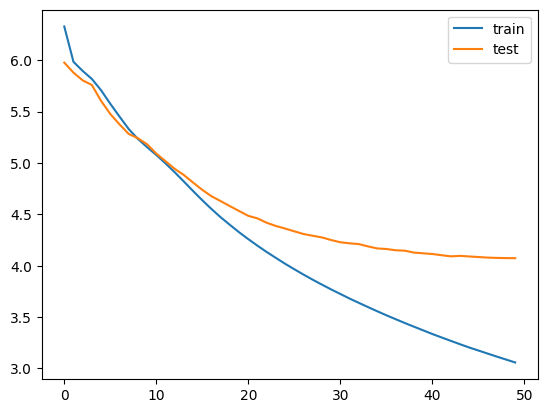

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기
- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 3개의 사전을 아래와 같이 준비한다.
<br/><br/>
seq2seq
- 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행
- 훈련 단계에서는 인코더와 디코더를 묶어 모델 하나만 준비한다.
<br/><br/>
인퍼런스 단계
- 정답이 없다.
- 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작
- 인퍼런스를 위한 모델 설계를 별도로 만든다.
- 인코더 모델과 디코더 모델을 분리해서 설계.



In [50]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- 어텐션 메커니즘을 사용하는 출력층을 설계

In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [56]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

- 원문의 정수 시퀀스를 텍스트 시퀀스로 변환

In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- 실제 요약과 예측된 요약문을 비교해보자.

In [83]:
for i in range(10):
    print("* 원문 :", seq2text(encoder_input_test[i]))
    print("* 실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("* 추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

* 원문 : ayurveda products including items baba ramdev patanjali found substandard quality haridwar ayurveda office rti reply revealed samples collected including patanjali divya amla juice failed test uttarakhand government lab report said patanjali md acharya balkrishna denied report 
* 실제 요약 : ramdev patanjali products fail uttarakhand quality test 
1/1 [==============================] - 0s 23ms/step
* 추상적 요약 :  patanjali announces scholarship for iit india


* 원문 : bjp released first list candidates upcoming rajasthan assembly elections retained sitting mlas added new names cm vasundhara raje contest represented since earlier reports claimed bjp chief amit shah raje differences finalising names candidates 
* 실제 요약 : rajasthan bjp sitting mlas in st candidate list 
1/1 [==============================] - 0s 22ms/step
* 추상적 요약 :  bjp releases first list of candidates for bjp assembly


* 원문 : uttar pradesh chief minister yogi adityanath sunday accused congress naxals naxalism chhattisga

- 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들을 보인다.


# Step 5. Summa을 이용해서 추출적 요약해보기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요.
- 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.
- Summa의 summarize를 사용하여 추출적 요약을 해보세요.

추상적 요약
- 원문에 없던 단어를 사용해서 요약
- 자유로운 텍스트 생성 모델(RNN, LSTM, Transformer 등)을 사용
- 정확성과 일관성이 유지되지 않을 수 있다.
<br/><br/>

추출적 요약
- 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문
- 언어 표현 능력이 제한되어 문장이 매끄럽지 않다.
- 대표적인 알고리즘 TextRank
- 요약에 포함될 문장을 선택하기 위해 문장 중요도를 평가하는 알고리즘(TF-IDF, 문장 중요도 그래프)을 사용.

- Summa의 suimmarize()의 인자로 사용되는 값
> text (str) - 요약할 텍스트.<br/>
> ratio (float, optional) - 요약문에서 원본에서 선택되는 문장 비율, 0~1 사이값<br/>
> words (int or None, optional) - 출력에 포함할 단어 수.<br/>
> 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.<br/>
> split (bool, optional) - True면 문장 list / False는 조인(join)된 문자열을 반환

In [79]:
import requests
import urllib.request
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

In [89]:
for i in range(10):
    print("* 원문 :", data['text'][i])
    print("* 실제 요약 :", data['headlines'][i])
    print("* 추출적 요약 :", summarize(data['text'][i], ratio=0.5))
    print("\n")

* 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
* 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
* 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


* 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
* 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
* 추출적 요약 : Users get one CRED coin per rup

- 아래는 추상적 요약(Abstractive Summarization)을 나타낸 표이다.
- 실제 요약과는 다른 내용으로 요약을 해내는 경우가 꽤 있다.

|headlines|추상적 요약|
|:---:|:---:|
|ramdev patanjali products fail uttarakhand quality test|patanjali announces scholarship for iit india|
|rajasthan bjp sitting mlas in st candidate list|bjp releases first list of candidates for bjp assembly|
|congress naxals as up cm yogi|bjp mla calls bjp workers in uttar pradesh|
|human foetus found near garbage dumping site in delhi|month old found found in delhi hospital|
|indian agency seeks us help in probing indigo engine smoke incident|killed in jet jet crashes off plane crashes in iran|

- 아래는 추출적 요약(Extractive Summarization)을 나타낸 표이다.
- 요약을 했지만 문장이 길다.

|headlines|추출적 요약|
|:---:|:---:|
|upGrad learner switches to career in ML & Al with 90% salary hike|upGrad's Online Power Learning has powered 3 lakh+ careers.|
|Delhi techie wins free food from Swiggy for one year on CRED|Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.|
|New Zealand end Rohit Sharma-led India's 12-match winning streak|The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.|
|Aegon life iTerm insurance plan helps customers save tax|Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.|
|Have known Hirani for yrs, what if MeToo claims are not true: Sonam|Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.|

- 요약적으로 따지자면 추출적 요약이 더 요약을 잘 한것같다.

# 회고
- 추상적 요약은 전처리를 하고 했지만 요약을 해보면 생각보다 원문과는 다른 내용을 보이고 있다. 다른 방식으로 전처리나 모델링을 해서 더욱 정확한 추상적 요약을 해보고싶다.
- 추출적 요약이 원문을 그대로 가져오다보니 더 요약을 잘하는 것같다.